In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time 
import datetime
%matplotlib inline

class RUN:
    timePerOrbit = 110*24.95
            
    def __init__(self, dataFrame):
        
        
        self.df = dataFrame
        self.events = len(self.df)

        
        self.orbitMin  = self.df['orbit'][:1].values[0]
        self.orbitMax  = self.df['orbit'][-1:].values[0] 
        self.nOrbits= self.orbitMax - self.orbitMin
        self.rectime   = self.nOrbits * RUN.timePerOrbit # in ns
        self.rectimeSECONDS   = self.nOrbits * RUN.timePerOrbit * 10**(-9) # in s
        
        if (self.df['run'][0] == self.df['run'][-1:].values[0]): # This code is not intended for use on merged runs
            self.run = self.df['run'][0]   
            TimeLogPath = "https://raw.githubusercontent.com/theofil/dscout/master/analysis/runsDateTimeLog.txt"
            TimeLog = pd.read_csv(TimeLogPath, delimiter = ', ', engine = 'python')

            for i in range(len(TimeLog['run'])):
                if TimeLog['run'][i] == self.run : 
                    index = i 
                    break

            duration = TimeLog['duration'][index]
            self.tStart = TimeLog['time_start'][index]
            self.tEnd = TimeLog['time_end'][index]
            h, m, s=duration.split(":")
            durationSecs = datetime.timedelta(hours = int(h), minutes = int(m), seconds = int(s)).total_seconds()
    #       --------------------------        
            self.duration = durationSecs
            self.naiveRate = self.events/durationSecs # in seconds
    #       --------------------------    
    
    def rate(self, timeUnit = 1, graph = False, info = False):
        
        orbitMin = self.orbitMin 
        orbitMax = self.orbitMax
        df = self.df['orbit']
        timeUnit = timeUnit*1e9 # desired time in seconds
        orbitsPerTimeUnit = timeUnit/RUN.timePerOrbit
        bins=int(self.nOrbits/orbitsPerTimeUnit) 
#         Depending on the time unit, some runs might have   orbitsPerTimeUnit > self.nOrbits
        if bins == 0: bins = 1  
        timePerBin = self.rectime/bins
        muons=np.zeros(bins)
        sclice=np.array([orbitMin+ ((orbitMax-orbitMin)/bins)*i for i in range(bins+1)])

        # Count the events in the first orbit = orbitMin
        for orbit in df:
            if(orbit > orbitMin): break
            if(orbit == orbitMin): muons[0] += 1

        df = df[int(muons[0]):] # We already counted the first orbit
        i = 0
        for orbit in df:
            while not (orbit > sclice[i] and orbit <= sclice[i + 1]) and i < bins-1: # Note the <= in 'orbit <= slicePlusOne[i]'. 
                i = i + 1                                                              # It is needed to capture the last orbit.
            muons[i] += 1

        # Maximum Likelihood Estimation of Poisson parameter
        Nmuons = int(muons.sum()) 
        Ninterval = len(muons) # How many time intervals

        mu = muons.mean()
        med = np.median(muons)
        sigma = muons.std()
        MLE = Nmuons/Ninterval

        # 99% Confidence interval under gaussian approximation

        error = 2.58 * np.sqrt(MLE/Ninterval)
        lower = MLE-error
        upper = MLE+error
        
        if (info):
        
            print('timePerOrbit %2.1f ns '%RUN.timePerOrbit)
            print('orbitMin %d orbitMax %d'%(self.orbitMin, self.orbitMax))
            print('nOrbits %d '%self.nOrbits)
            print('total recording time %2.4f ns (~= %2.1f s)' %(self.rectime, self.rectime*1.e-9))
            print('orbitsPerTimeUnit = %2.3f'%orbitsPerTimeUnit)
            print("bins = %d" %bins)
            print('--------------------------------')
            print('mean = {:.2f}' .format(mu))
            print('median = {:d}'.format(int(med)))             
            print('sample std = {:.2f}'.format( sigma))
            #print('Gaussian 99% Confidence Interval = [{:.2f} , {:.2f} ]'.format(lower, upper))
            
        if (graph):
            
            if style == 1:
                
                muons = pd.Series(muons)
                counts = muons.value_counts().sort_index()
                
                plt.figure(figsize=(8,8))
                plt.errorbar(counts.index, counts.values, xerr = None, yerr = np.sqrt(counts.values), fmt = 'o')
                plt.xlabel('nMuons / %2.1f s'%(timePerBin*1.e-9), fontsize = 20) # latex can be entered in the label's string
                plt.ylabel('Frequency', fontsize = 20)

                plt.show()
                
            if style == 2:
            
                muons = np.array(muons)
                counts, binEdges = numpy.histogram(muons, bins=len(muons))

                bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
                menStd     = np.sqrt(counts)
                width      = 1

                plt.figure(figsize=(8,8))
                plt.bar(bincenters, counts, width=width, color='b', ecolor = 'r', yerr=menStd, error_kw = {'alpha': 1})
                plt.xlabel('nMuons / %2.1f s'%(timePerBin*1.e-9), fontsize = 20) # latex can be entered in the label's string
                plt.ylabel('Frequency', fontsize = 20)

                plt.show()

        return mu  # muons.mean() is the rate (events per timeUnit)


    def plotPhi(self):
        
        phiticks = [0.5*np.pi*i for i in range(-2,3)]
        plt.rc('font', size=22)
        plt.figure(figsize=(8,8))
        plt.hist(self.df['phi'], bins = 30, histtype = 'bar', ec='black')
        plt.xticks(phiticks)
        plt.xlabel('$\phi$ [radians]')
        plt.ylabel('# muon candidates')
        plt.show()
        

In [2]:
def pair(df, x):

    dfns = df.shift(-x)
    dfps = df.shift(+x)

    logicOS1 = (df.bx == dfns.bx - x) & (df.orbit == dfns.orbit) & (df.charge*dfns.charge < 0)
    OS1 = df[logicOS1].copy()

    logicOS2 = (df.bx == dfps.bx + x) & (df.orbit == dfps.orbit) & (df.charge*dfps.charge < 0)
    OS2 = df[logicOS2].copy()

    OS1 = OS1.reset_index()
    OS2 = OS2.reset_index()

    OS = OS1.merge(OS2, left_on=OS1.index, right_on=OS2.index, suffixes=('_in', '_out'))

    logicSS1 = (df.bx == dfns.bx - x) & (df.orbit == dfns.orbit) & (df.charge*dfns.charge > 0)
    SS1 = df[logicSS1].copy()

    logicSS2 = (df.bx == dfps.bx + x) & (df.orbit == dfps.orbit) & (df.charge*dfps.charge > 0)
    SS2 = df[logicSS2].copy()

    SS1 = SS1.reset_index()
    SS2 = SS2.reset_index()

    SS = SS1.merge(SS2, left_on=SS1.index, right_on=SS2.index, suffixes=('_in', '_out'))

    # slim the dataframes
    def slimDataFrame(df):
        df = df.drop(['run_in', 'index_in','index_out','key_0','orbit_out'], axis=1)
        df = df.rename(columns = {'run_out':'run','orbit_in':'orbit'})
        if False: df = df.set_index(['run','orbit','bx_in'])
        return df

    OS = slimDataFrame(OS)
    SS = slimDataFrame(SS)
    return (OS, SS)

In [6]:
TimeLogPath = "https://raw.githubusercontent.com/theofil/dscout/master/analysis/runsDateTimeLog.txt"
goodPath = './data/goodRuns/'
badPath = './data/badRuns/'
twoLegPath = './data/2LegGood/'
def timeAnalysis(path, TwoLeg = False):
    # data files
    #path = './data/goodRuns/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
    files = os.listdir(path)
    files = [f for f in files]

    # list to hold dataframes
    dfList = []
    absRate = []
    duration = []
    rectime = []
    runNo = []
    for file in files:
        filepath = path+file
        df = pd.read_csv(filepath)
        dfList.append(df)
    
        runNo.append(int(file.split('.')[0]))
        if TwoLeg:
            df.drop(['bx_out','phi_out','eta_out','pt_out','charge_out'], axis = 1)
            df.rename({'bx_in': 'bx', 'phi_in': 'phi','eta_in': 'eta', 'pt_in': 'pt', 'charge_in': 'charge'})
        runObj = RUN(df)

        absRate.append(runObj.events/runObj.rectimeSECONDS)
        duration.append(runObj.duration)
        rectime.append(runObj.rectimeSECONDS)
        
    absRate = np.array(absRate)
    duration = np.array(duration)
    rectime = np.array(rectime)
    events = np.array([len(df) for df in dfList])
    absRateErr = np.sqrt(events)/rectime
    
    
    TimeLog1 = pd.read_csv(TimeLogPath, delimiter = ', ', engine = 'python')


    # Keep only the good runs 

    TimeLog = TimeLog1[TimeLog1.loc[:,'run'].isin(runNo)].copy()
    TimeLog.reset_index(drop=True, inplace=True) 


    # Convert all times into seconds for ease of use. 

    for column in ['duration', 'time_start', 'time_end']:
        for i in range(len(TimeLog)):
            h , m, s = TimeLog.loc[i, column].split(':')
            value = datetime.timedelta(hours = int(h), minutes = int(m), seconds = int(s)).total_seconds()
            TimeLog.loc[i, column] = value


    # The values set above are the number of seconds since last midnight. 
    # That means that we will not see the start time of the runs that end there, so we move them on to the next day 
    # Add the duration to the end time of the runs that end on the next day

    for i in range(len(TimeLog)):
        if TimeLog.loc[i, 'date_start'] != TimeLog.loc[i, 'date_end']: TimeLog.loc[i, 'time_end'] += TimeLog.loc[i,'duration']


    # We want the data points to be in the time center of the run, so we define the midpoint

    TimeLog.loc[:, 'midpoint'] = TimeLog.loc[:, 'time_start'] + TimeLog.loc[:, 'duration']/2
    TimeLog.loc[:, 'rate'] = pd.Series(data = absRate)
    TimeLog.loc[:, 'rateErr'] = pd.Series(data = absRateErr)
    nextDay = TimeLog[TimeLog.loc[:, 'date_start'] != TimeLog.loc[:, 'date_end']].copy()
    nextDay.reset_index(drop=True, inplace=True) 
    # np.arrays for ease of use

    midpoints = np.array(TimeLog.loc[:, 'midpoint'].to_list())
    duration = np.array(TimeLog.loc[:, 'duration'].to_list())
    rate = np.array(TimeLog.loc[:, 'rate'].to_list())
    rateErr = np.array(TimeLog.loc[:, 'rateErr'].to_list())
    nextMidpoints = np.array(nextDay.loc[:, 'midpoint'].to_list())
    nextDuration = np.array(nextDay.loc[:, 'duration'].to_list())
    nextRate = np.array(nextDay.loc[:, 'rate'].to_list())
    nextRateErr = np.array(nextDay.loc[:, 'rateErr'].to_list())

    # After moving the runs to the next day, now they do not appear in the start of the day
    # we copy (data - daySecs) to data by merging 
    daySecs = 86400
    midpoints = np.concatenate((midpoints, nextMidpoints-daySecs), axis = None)
    rate =  np.concatenate((rate, nextRate), axis = None)
    rateErr = np.concatenate((rateErr, nextRateErr), axis = None)
    midpointsErr = np.concatenate((duration/2,nextDuration/2) , axis = None)



    return (duration, rectime, midpoints, midpointsErr, rate, rateErr)

In [5]:
# # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# # \\                                                                                                       \\ 
# # \\ THIS CELL SAVES THE GOODRUNS AND THE BADRUNS IN A SEPARATE FOLDER AFTER FIXING THE ORBIT NUMBER RESET \\
# # \\                                                                                                       \\
# # \\                                     NO NEED TO RUN MORE THAN ONCE                                     \\
# # \\                                                                                                       \\
# # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


# #Original code for this cell at https://github.com/theofil/dscout/blob/master/analysis/exampleAnalysis.ipynb
# import numpy as npW
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import subprocess
# import bz2
# %matplotlib inline

# plt.rc('font', size=15)



# # data files
# path = './data/hiion/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
# files = os.listdir(path)
# files = [f for f in files if 'monitor' not in f]

# # getrunNumber from string e.g., int('/data/hiion/scout_326676_000000.monitor.txt'.split('_')[1]
# getRun = lambda x: int(x.split('_')[1])



# # list to hold dataframes
# dfs = []
# runIndex= []

# for file in files:
#     filepath = path+file
#     df = pd.read_csv(filepath)
    
  
#     # add a column with the run number
#     df['run'] = getRun(file) 
#     dfs += [df]
    
#     #make in index with the run numbers
#     runIndex += [getRun(file)]
# plt.rc('figure', max_open_warning = 100)


# #Fix the runs where the orbit number resets (the warning does not matter)

# for df in dfs:
#     if not df['orbit'].is_monotonic:
#         for i in range(1,len(df)):
#             if df['orbit'][i-1]>df['orbit'][i]:
#                 tmp = i-1
#                 break
#         df['orbit'][tmp+1:] = df['orbit'][tmp] + df['orbit'][tmp+1:]

        
# badruns = [0, 1, 4, 8, 9, 11, 28, 30, 33, 34, 35, 36, 39, 46, 47, 50,  57, 65, 68, 69, 70, 72, 77, 78]
# goodruns = [i for i in range(len(dfs)) if i not in badruns]

# dfg = [] #data frame with only goodruns
# dfb = [] #data frame with only baddruns

# for i in range(len(dfs)):
#     if i in goodruns : dfg.append(dfs[i])
#     if i in badruns : dfb.append(dfs[i])
        
# for df in dfg:
#     name = str(df['run'][0])+".txt"
#     df.to_csv("./data/goodRuns/"+name, index = False) # The folder goodRuns needs to be manually made
#     OS, SS = pair(df, 1)
#     OS.to_csv("./data/2LegGood/"+name, index = False) # The folder 2LegGood needs to be manually made
    
# for df in dfb:
#     name = str(df['run'][0])+".txt"
#     df.to_csv("./data/badRuns/"+name, index = False) # The folder baddRuns needs to be manually made
    


In [7]:
GOOD_duration, GOOD_rectime, GOOD_midpoints, GOOD_midpointsErr, GOOD_rate, GOOD_rateErr = timeAnalysis(goodPath)
BAD_duration, BAD_rectime, BAD_midpoints, BAD_midpointsErr, BAD_rate, BAD_rateErr = timeAnalysis(badPath)
GOOD_timeRatio = GOOD_duration/GOOD_rectime


# Plots

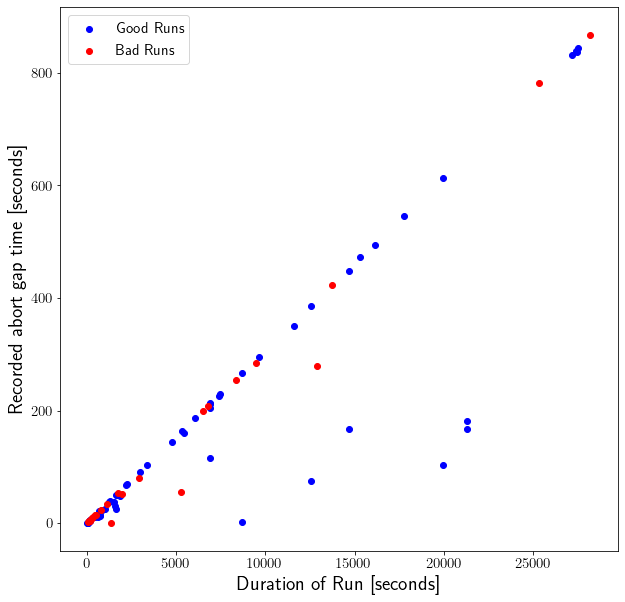

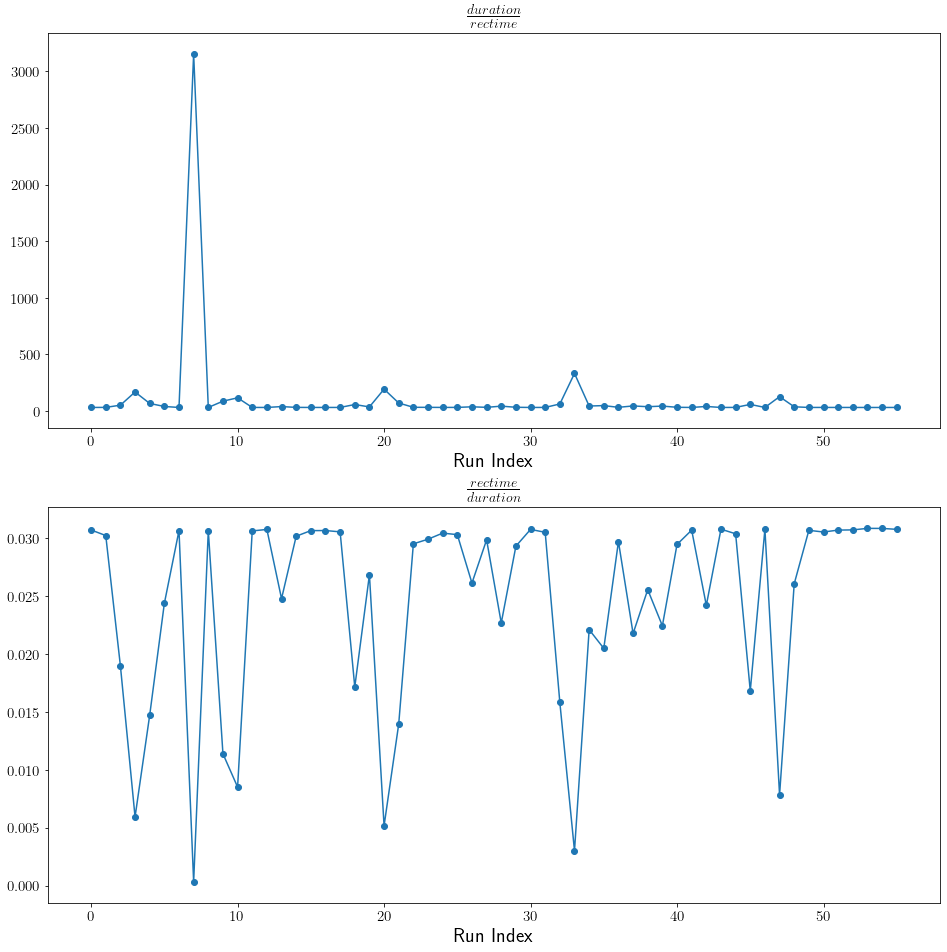

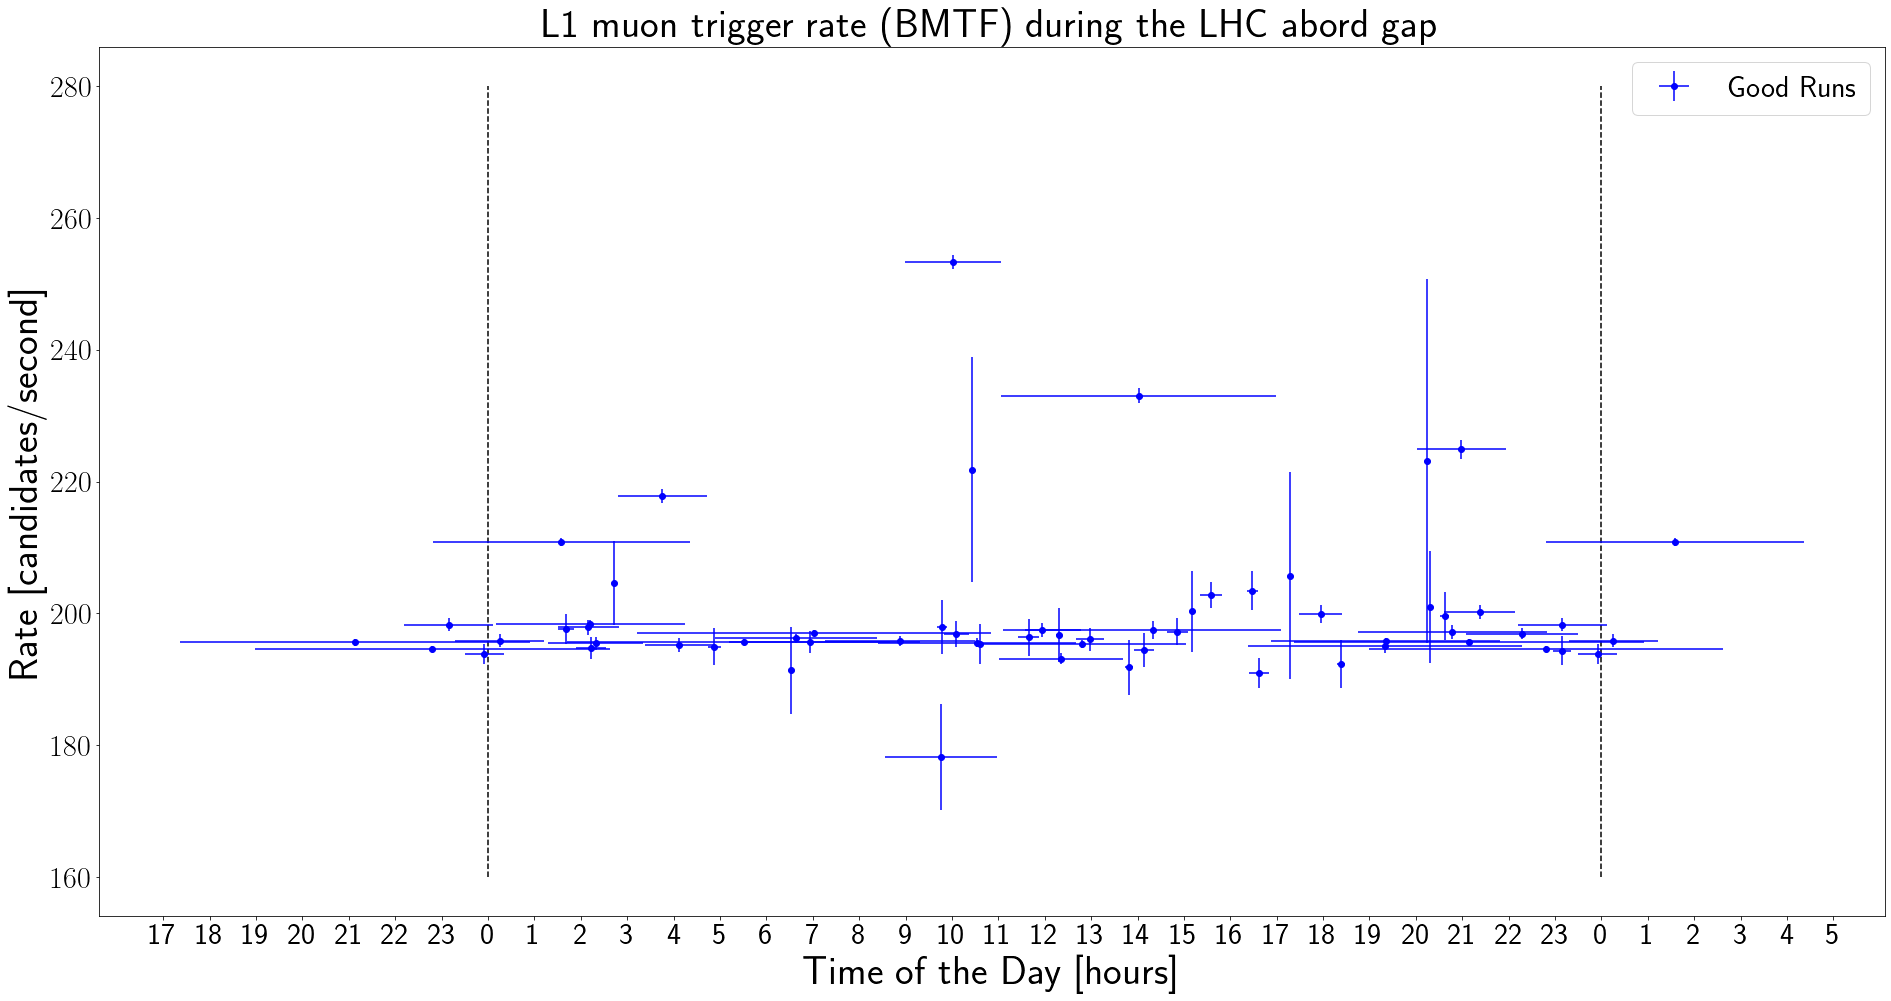

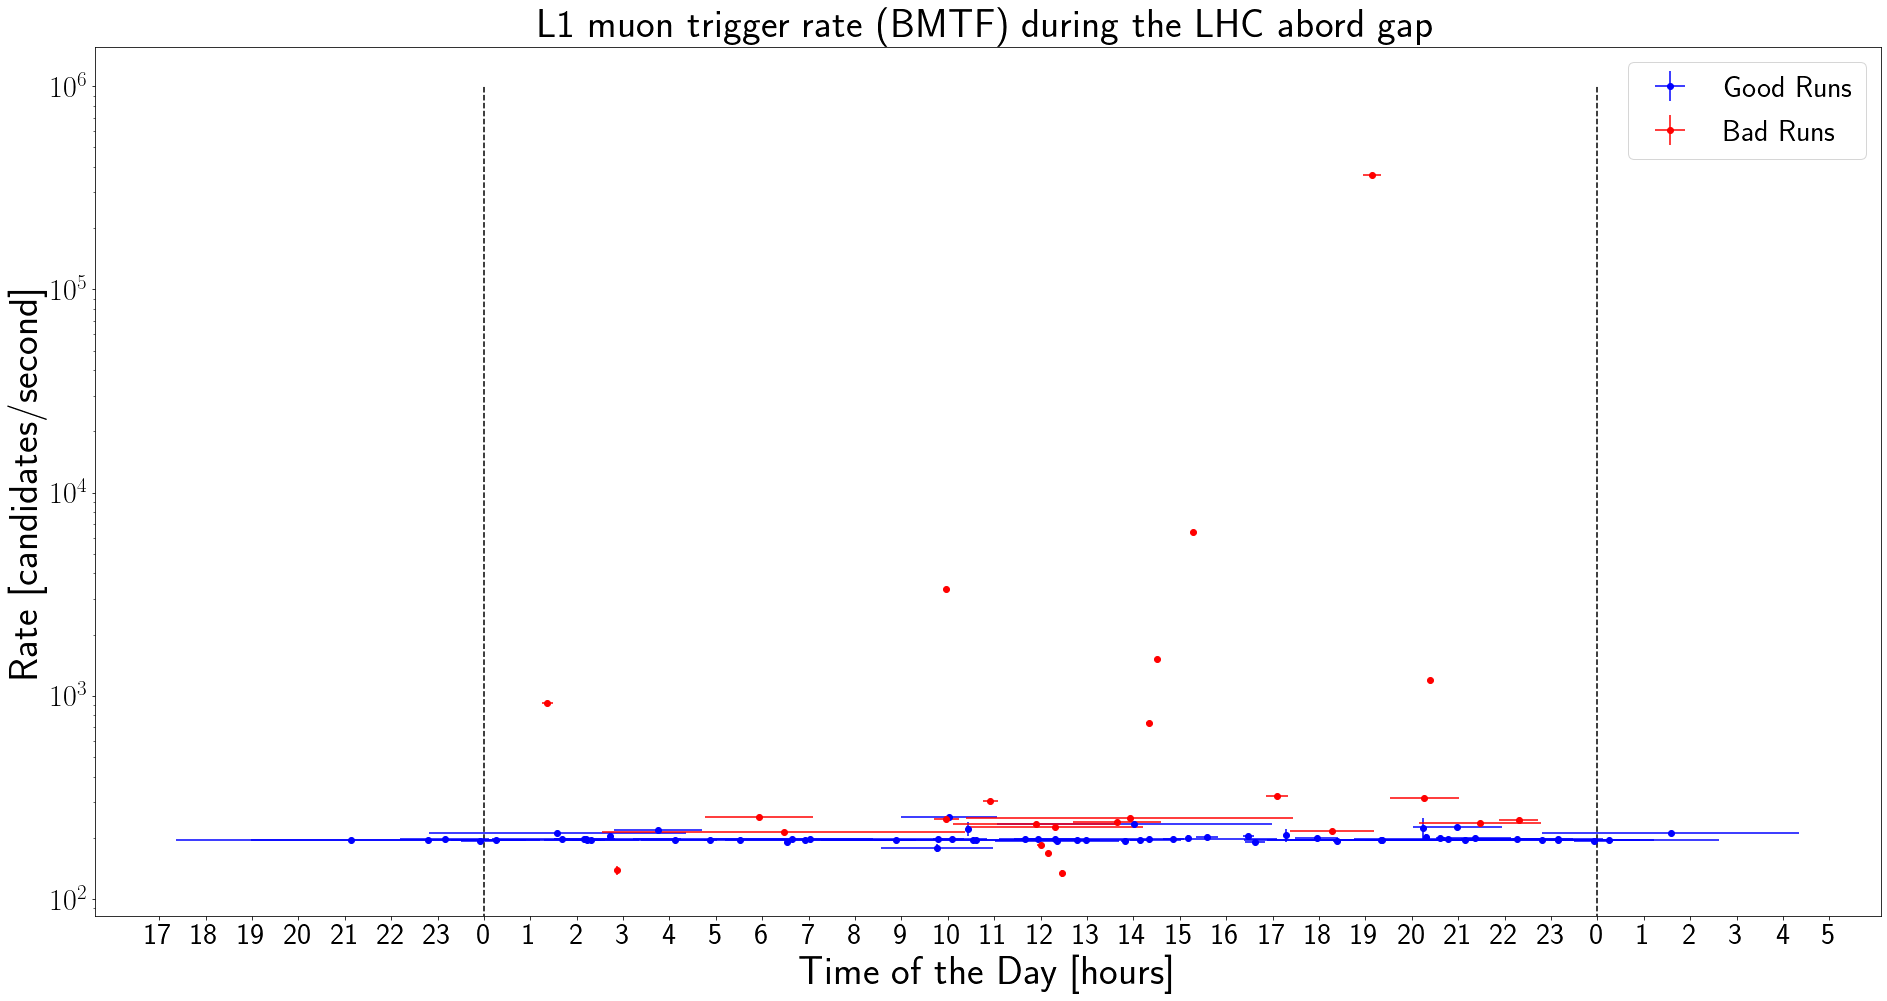

In [11]:
# Duration - Rectime PLOT
plt.figure(figsize = (10,10))
plt.scatter(GOOD_duration,GOOD_rectime, c= 'blue', label = 'Good Runs')
plt.scatter(BAD_duration,BAD_rectime, c = 'red', label = 'Bad Runs')
plt.xlabel('Duration of Run [seconds]', fontsize = 20)
plt.ylabel('Recorded abort gap time [seconds]', fontsize = 20)
plt.legend()

plt.show()


# Time Ratio PLOT
fig = plt.figure(figsize = (16,16))
plt.rc('text', usetex=True)
ax1 = fig.add_subplot(2,1,1)


ax1.plot([i for i in  range(len(GOOD_timeRatio))], GOOD_timeRatio)
ax1.scatter([i for i in  range(len(GOOD_timeRatio))], GOOD_timeRatio)
ax1.set_xlabel('Run Index',  fontsize = 20)
ax1.set_title(r'$\frac{duration}{rectime}$', fontsize = 20)

ax2 = fig.add_subplot(2,1,2, sharex = ax1)


ax2.plot([i for i in  range(len(GOOD_timeRatio))], 1/GOOD_timeRatio)
ax2.scatter([i for i in  range(len(GOOD_timeRatio))], 1/GOOD_timeRatio)
ax2.set_xlabel('Run Index',  fontsize = 20)
ax2.set_title(r'$\frac{rectime}{duration}$', fontsize = 20)

plt.show()

#Rate per time PLOT


plt.figure(figsize = (32, 16))
plt.title('L1 muon trigger rate (BMTF) during the LHC abord gap', size = 40)

plt.ylabel('Rate [candidates/second]', size = 40)
plt.xlabel('Time of the Day [hours]', size = 40)
label = [i for i in range(17, 24)] + [i for i in range(24)] + [i for i in range(6)]
tick = [i for i in range(-25200, 104401, 3600)]
plt.xticks(ticks = tick, labels = label, size = 30 )
plt.yticks(size = 30)
daySecs = 86400
plt.vlines([0,daySecs], 160, 280, colors = 'black', linestyle = 'dashed') # 160 - 280
plt.errorbar(GOOD_midpoints, GOOD_rate, yerr = GOOD_rateErr, xerr = GOOD_midpointsErr,  fmt='o', c = "blue", label = 'Good Runs')
plt.legend(fontsize = 30)
# plt.savefig('./Plots/RatePerTime.pdf')
plt.show()

#Rate per time PLOT


plt.figure(figsize = (32, 16))
plt.title('L1 muon trigger rate (BMTF) during the LHC abord gap', size = 40)

plt.ylabel('Rate [candidates/second]', size = 40)
plt.xlabel('Time of the Day [hours]', size = 40)
label = [i for i in range(17, 24)] + [i for i in range(24)] + [i for i in range(6)]
tick = [i for i in range(-25200, 104401, 3600)]
plt.xticks(ticks = tick, labels = label, size = 30 )
plt.yticks(size = 30)
daySecs = 86400
plt.vlines([0,daySecs], 0, 10e5, colors = 'black', linestyle = 'dashed') # 160 - 280
plt.errorbar(GOOD_midpoints, GOOD_rate, yerr = GOOD_rateErr, xerr = GOOD_midpointsErr,  fmt='o', c = "blue", label = 'Good Runs')
plt.errorbar(BAD_midpoints, BAD_rate, yerr = BAD_rateErr, xerr = BAD_midpointsErr,  fmt='o', c = "red", label = 'Bad Runs')
plt.yscale('log')
plt.legend(fontsize = 30)
# plt.savefig('./Plots/RatePerTime_withBAD.pdf')
plt.show()

# Two-Leg

In [9]:
TWO_duration, TWO_rectime, TWO_midpoints, TWO_midpointsErr, TWO_rate, TWO_rateErr = timeAnalysis(twoLegPath)

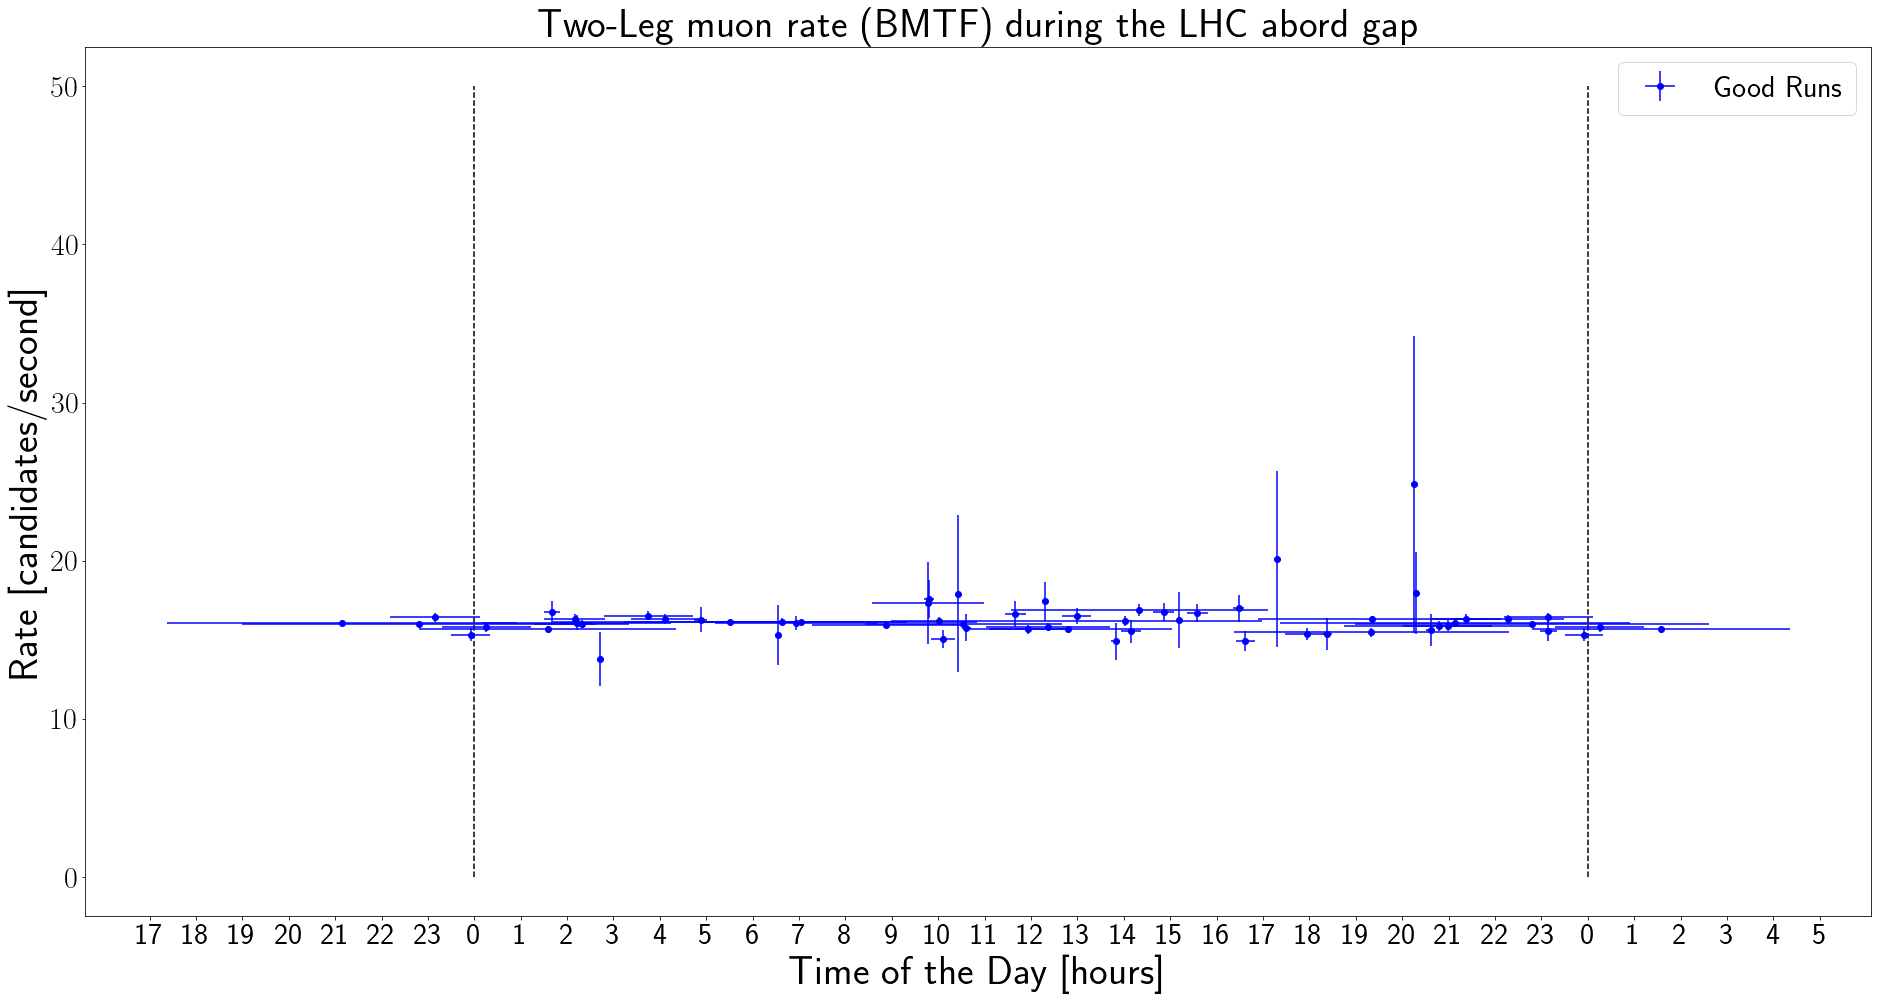

In [16]:
plt.figure(figsize = (32, 16))
plt.title('Two-Leg muon rate (BMTF) during the LHC abord gap', size = 40)

plt.ylabel('Rate [candidates/second]', size = 40)
plt.xlabel('Time of the Day [hours]', size = 40)
label = [i for i in range(17, 24)] + [i for i in range(24)] + [i for i in range(6)]
tick = [i for i in range(-25200, 104401, 3600)]
plt.xticks(ticks = tick, labels = label, size = 30 )
plt.yticks(size = 30)
daySecs = 86400
plt.vlines([0,daySecs], 0, 50, colors = 'black', linestyle = 'dashed') # 160 - 280
plt.errorbar(TWO_midpoints, TWO_rate, yerr = TWO_rateErr, xerr = TWO_midpointsErr,  fmt='o', c = "blue", label = 'Good Runs')
plt.legend(fontsize = 30)
# plt.savefig('./Plots/TwoLegRatePerTime.pdf')
plt.show()
